In [1]:
import os
import re 
import numpy as np 
import pandas as pd
import seaborn as sns 
from collections import Counter
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
plt.style.use('ggplot')
# import xgboost as xgb

In [2]:
ROOT_DIR = "./dataset"
FILE = "listings.csv"
FILE_PATH = os.path.join(ROOT_DIR, FILE)

# Overview of the data 

In [3]:
def load_data(PATH=FILE_PATH):
    return pd.read_csv(PATH)

df = load_data()

In [4]:
print(df.info())
print("Different data types:")
print(Counter(list(df.dtypes)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45815 entries, 0 to 45814
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45815 non-null  int64  
 1   listing_url                                   45815 non-null  object 
 2   scrape_id                                     45815 non-null  int64  
 3   last_scraped                                  45815 non-null  object 
 4   source                                        45815 non-null  object 
 5   name                                          45813 non-null  object 
 6   description                                   44894 non-null  object 
 7   neighborhood_overview                         26751 non-null  object 
 8   picture_url                                   45815 non-null  object 
 9   host_id                                       45815 non-null 

## Relevant Columns and Rows 

First, we note that we wil only be dealing with Airbnb listings in the City of Los Angeles, therefore, we filter out the rows including details of properties from other cities. We see that the `neighbourhood_group_cleansed` variable contains information on the city level.

In [5]:
df.loc[:, "neighbourhood_group_cleansed"].value_counts()

City of Los Angeles     19501
Other Cities            14849
Unincorporated Areas     3576
Name: neighbourhood_group_cleansed, dtype: int64

In [6]:
la_df = df[df.loc[:, "neighbourhood_group_cleansed"] == "City of Los Angeles"]

We also look at the different room types available for the properties in our dataset. For our analysis, we do not count for the properties that have been listed as hotel rooms since the purpose of our analyses is to figure out the average prices for the general consumer to list their properties at. 

In [7]:
la_df.loc[:, 'room_type'].value_counts()

Entire home/apt    14507
Private room        4400
Shared room          567
Hotel room            27
Name: room_type, dtype: int64

In [8]:
la_df = la_df[la_df.loc[:, "room_type"] != "Hotel room"]
la_df.reset_index(drop=True, inplace=True)

`la_df` will hence be the relevant subset of data that we will perform our analysis on.

Next, we broadly look at some of the features that will be relevant for our analyses. Once we have a smaller subset of features to work with, we can then move on to preparing our data for our machine learning models.

1. Firstly, we will remove the columns that just have metadata information about the listings such as host_id, url, images, date at which the listing was scraped since these columns do not contribute anything meaningful to our analysis.

In [9]:
filtered_cols = ["id", "name", "host_id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_url", "host_thumbnail_url", "host_picture_url",
                "calendar_updated", "calendar_last_scraped", "description", "neighborhood_overview", "host_about", "host_since",
                "host_name", "host_location", "host_has_profile_pic", "host_neighbourhood","last_review", "first_review", "has_availability"]
la_df_filtered = la_df.drop(columns=filtered_cols).copy()
la_df_filtered.shape

(19474, 51)

2. Secondly, we consider columns that have a huge proportion of NULL values and hence will not be able to add meaningful information to our analyses.

In [10]:
na_list = la_df_filtered.isna().sum()[lambda x: x > 0].sort_values(ascending=False)
print(na_list)
print(f"Number of NA Columns: {len(na_list)}")

bathrooms                      19474
license                        11720
neighbourhood                   7750
review_scores_value             5693
review_scores_location          5692
review_scores_checkin           5691
review_scores_accuracy          5687
review_scores_communication     5686
review_scores_cleanliness       5686
reviews_per_month               5539
review_scores_rating            5539
host_response_time              4970
host_response_rate              4970
host_acceptance_rate            4591
bedrooms                        2186
beds                             442
host_is_superhost                 41
bathrooms_text                    32
host_identity_verified             2
host_total_listings_count          2
host_listings_count                2
dtype: int64
Number of NA Columns: 21


Here, we see that 21 columns have at least one NA value. Some columns such as bathrooms and license, host_response_rate, host_response_time, host_acceptance_rate have too many NULL values (and are difficult to impute for) to make any relevant impact on our analyses. Therefore, we get rid of them entirely. For the neighbourhood column, we see that we have a more relevant column called neighbourhood_cleansed that has far fewer NULL values. For the review columns, we can try imputation strategies to overcome the NULL value issue. Lastly, there are other columns such as maximum_minimum_nights, host_listings_count etc that may be replaced by other more pertinent columns/removed entirely.

In [11]:
relevant_cols = ['host_is_superhost', 'host_total_listings_count', 'host_verifications', 'host_identity_verified',
                'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type',
                'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
                'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
                'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
                'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                'reviews_per_month']
la_df_na = la_df_filtered.loc[:, relevant_cols]
la_df_na.head(3)

,host_is_superhost,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,f,3.0,"['email', 'phone']",f,Venice,City of Los Angeles,33.99211,-118.47600,Entire rental unit,Entire home/apt,...,5.00,5.00,5.00,5.00,f,2,2,0,0,0.02
1,f,2.0,"['email', 'phone']",t,Atwater Village,City of Los Angeles,34.12206,-118.26783,Entire bungalow,Entire home/apt,...,4.89,4.85,4.95,4.76,f,2,2,0,0,0.98
2,f,2.0,"['email', 'phone', 'work_email']",t,Venice,City of Los Angeles,33.97487,-118.46312,Entire rental unit,Entire home/apt,...,4.78,4.93,4.89,4.85,t,1,1,0,0,0.22


Now with these 38 columns, we will make our final data subset by considering correlations of these columns with the target variable 'price' and also amongst themselves to make sure that we select features that have a high influence on price and are also not very correlated with each other to reduce the risk redundancy and poor performance.

However, to do this, we will need to clean some of the features as well as the target variable to transform them into a numeric format, ready for our machine learning models. 

# Data Cleaning

In [12]:
la_df_na['price']

0        $152.00
1         $75.00
2        $125.00
3        $189.00
4         $85.00
          ...   
19469    $500.00
19470    $109.00
19471    $274.00
19472    $317.00
19473     $98.00
Name: price, Length: 19474, dtype: object

First, we will clean up the `price` column and transform it into a numeric format. 

In [13]:
def clean_price(x):
    x = x.split("$")[1]
    x = re.sub(",", "", x)
    return float(x)

la_df_na['price'] = la_df_na['price'].apply(clean_price)
la_df_na['price']

0        152.0
1         75.0
2        125.0
3        189.0
4         85.0
         ...  
19469    500.0
19470    109.0
19471    274.0
19472    317.0
19473     98.0
Name: price, Length: 19474, dtype: float64

Now, we explore our target variable further and understand its distribution. 

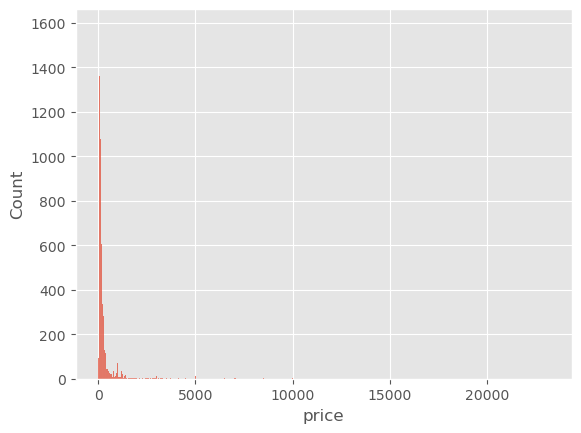

In [14]:
sns.histplot(data=la_df_na, x='price')
plt.show()

Through this visualization, we note that our target variable is highly skewed and thus, would not result in very good results if used as is. Therefore, we log-transform the price variable to make it more symmetric. 

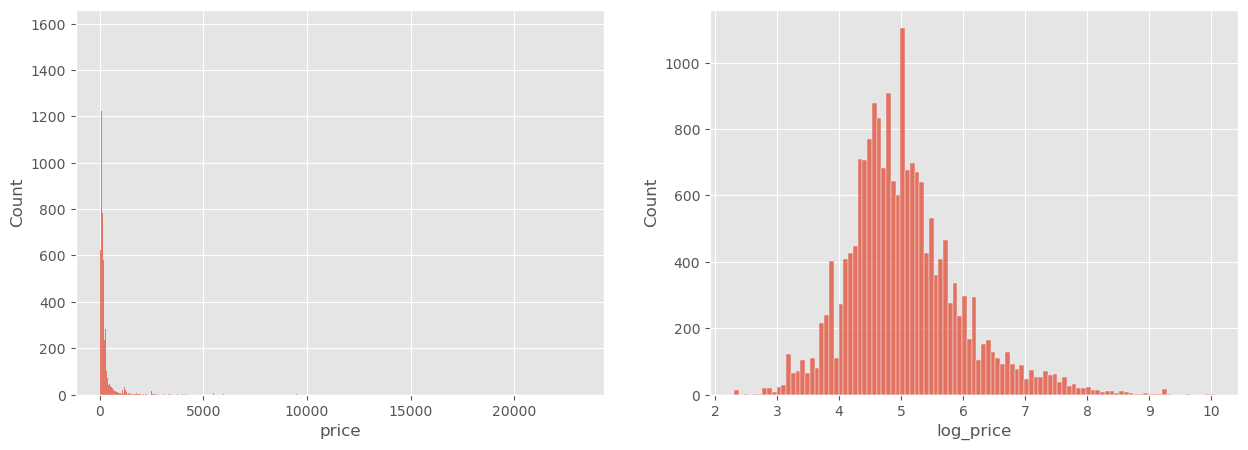

In [15]:
# Log-Transformation of price
la_df_na['log_price'] = np.log(la_df_na['price'])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data=la_df_na, x='price')
sns.histplot(ax=axes[1], data=la_df_na, x='log_price')
plt.show()

Having converted the price column to a numeric format and explored its distribution, we now plot these prices against the latitude and longitude of the different regions in the dataset. This helps get a sense of the differentiation in price of the properties based on their location.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


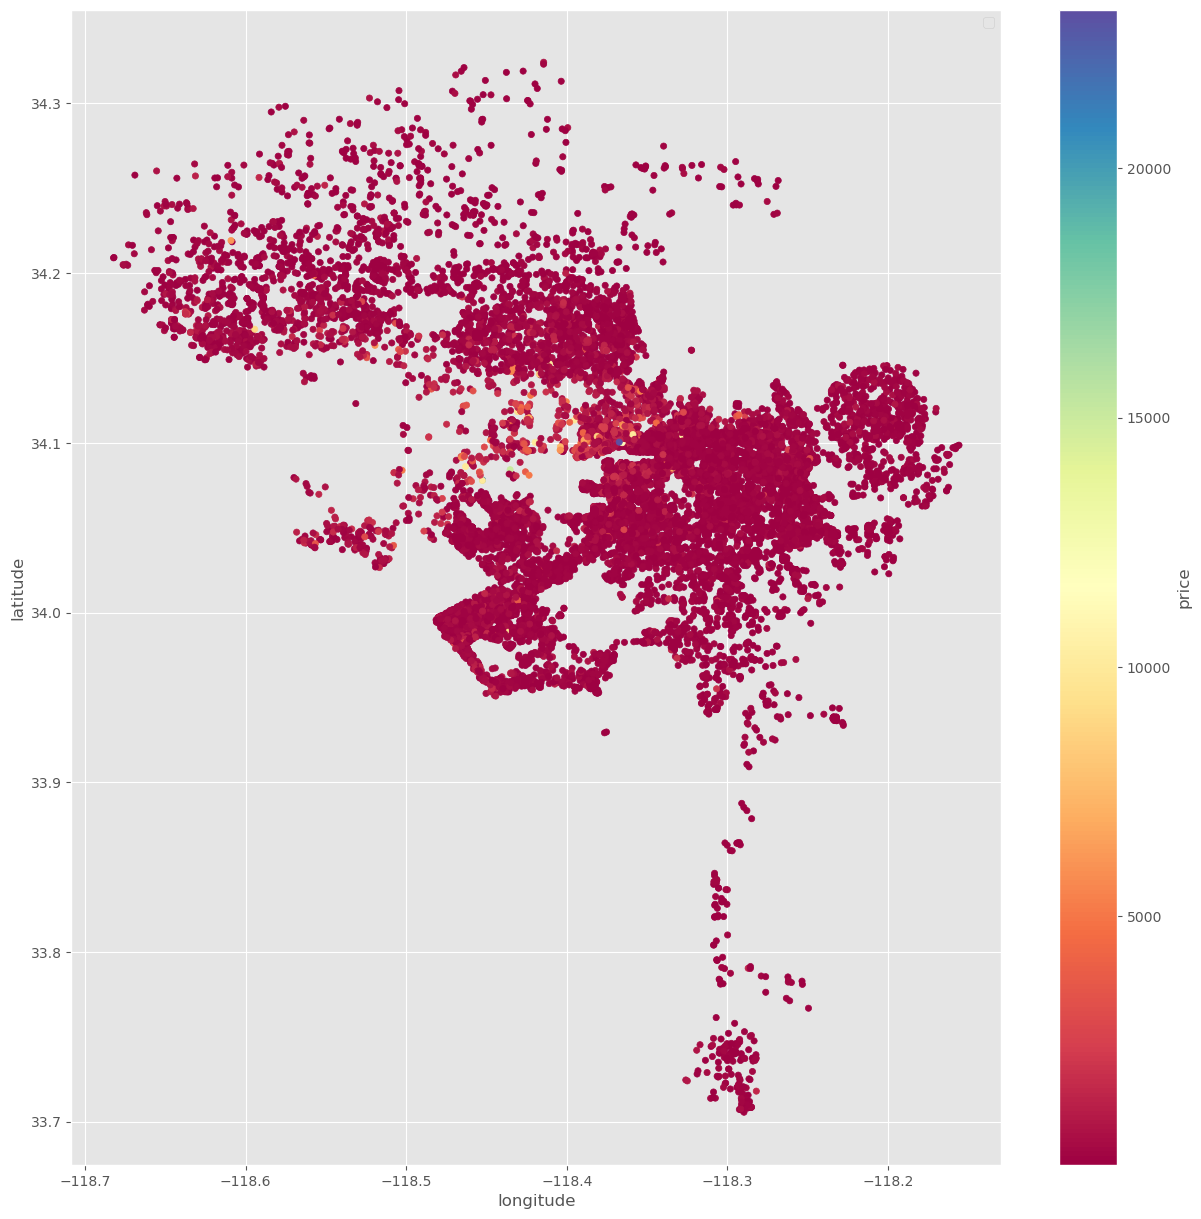

In [16]:
la_df_na.plot(kind="scatter", x="longitude", y="latitude", alpha=1.0,figsize=(15,15),
c="price", cmap=plt.get_cmap("Spectral"), colorbar=True,
)
plt.legend()
plt.show()

Through this visualization, we see that there is a horizontal strip near the latitude of 34.1 deg that has high values for listings. This suggests us to include the neighbourhood column for our analysis as it may prove to be an important feature variable.

Hence, to use this variable, we ONE-HOT encode it, to create binary variables for each of the different neighbourhoods in the data. Since there are 113 different neighbourhoods, we create 113 different binary columns. 

In [17]:
la_df_na.neighbourhood_cleansed.value_counts()

Hollywood               1632
Venice                  1535
Downtown                1006
Sherman Oaks             878
Hollywood Hills          713
                        ... 
Harvard Park               6
Green Meadows              6
Lake View Terrace          4
Sepulveda Basin            4
Chatsworth Reservoir       3
Name: neighbourhood_cleansed, Length: 113, dtype: int64

In [18]:
la_df_neighbourhoods = pd.get_dummies(la_df_na.loc[:, 'neighbourhood_cleansed'], prefix = 'neighbourhood_OHE')
la_df_neighbourhoods = pd.concat([la_df_na, la_df_neighbourhoods], axis=1)
la_df_na = la_df_neighbourhoods.copy()

Next, we look at processing the different features in a relevant manner. 

* Converting the boolean columns into 0 and 1 

In [19]:
def f(x):
    return 1 if x == 't' else 0
la_df_na['host_is_superhost'] = la_df_na['host_is_superhost'].apply(f)
la_df_na['host_identity_verified'] = la_df_na['host_identity_verified'].apply(f)
la_df_na['instant_bookable'] = la_df_na['instant_bookable'].apply(f)

We also check for any signficance in the difference of means between the boolean categories of each of these four variables. Through this, we note that the host having their identity verified does add to the price. On the other hand, the property being instantly bookable actually reduces the average price of a property. This may be justified since the property that is instantly bookable may not be in high demand and hence have a lower listed price. 

However, the average price properties of superhosts being lower than that of the prices of properties of non-superhosts was a surprising result. But, we note that these differences need to be considered with a pinch of salt given the imbalance in our data for the categories in each of these variables. The average price for properties is higher for the class that has more data points in all 3 of these variables.

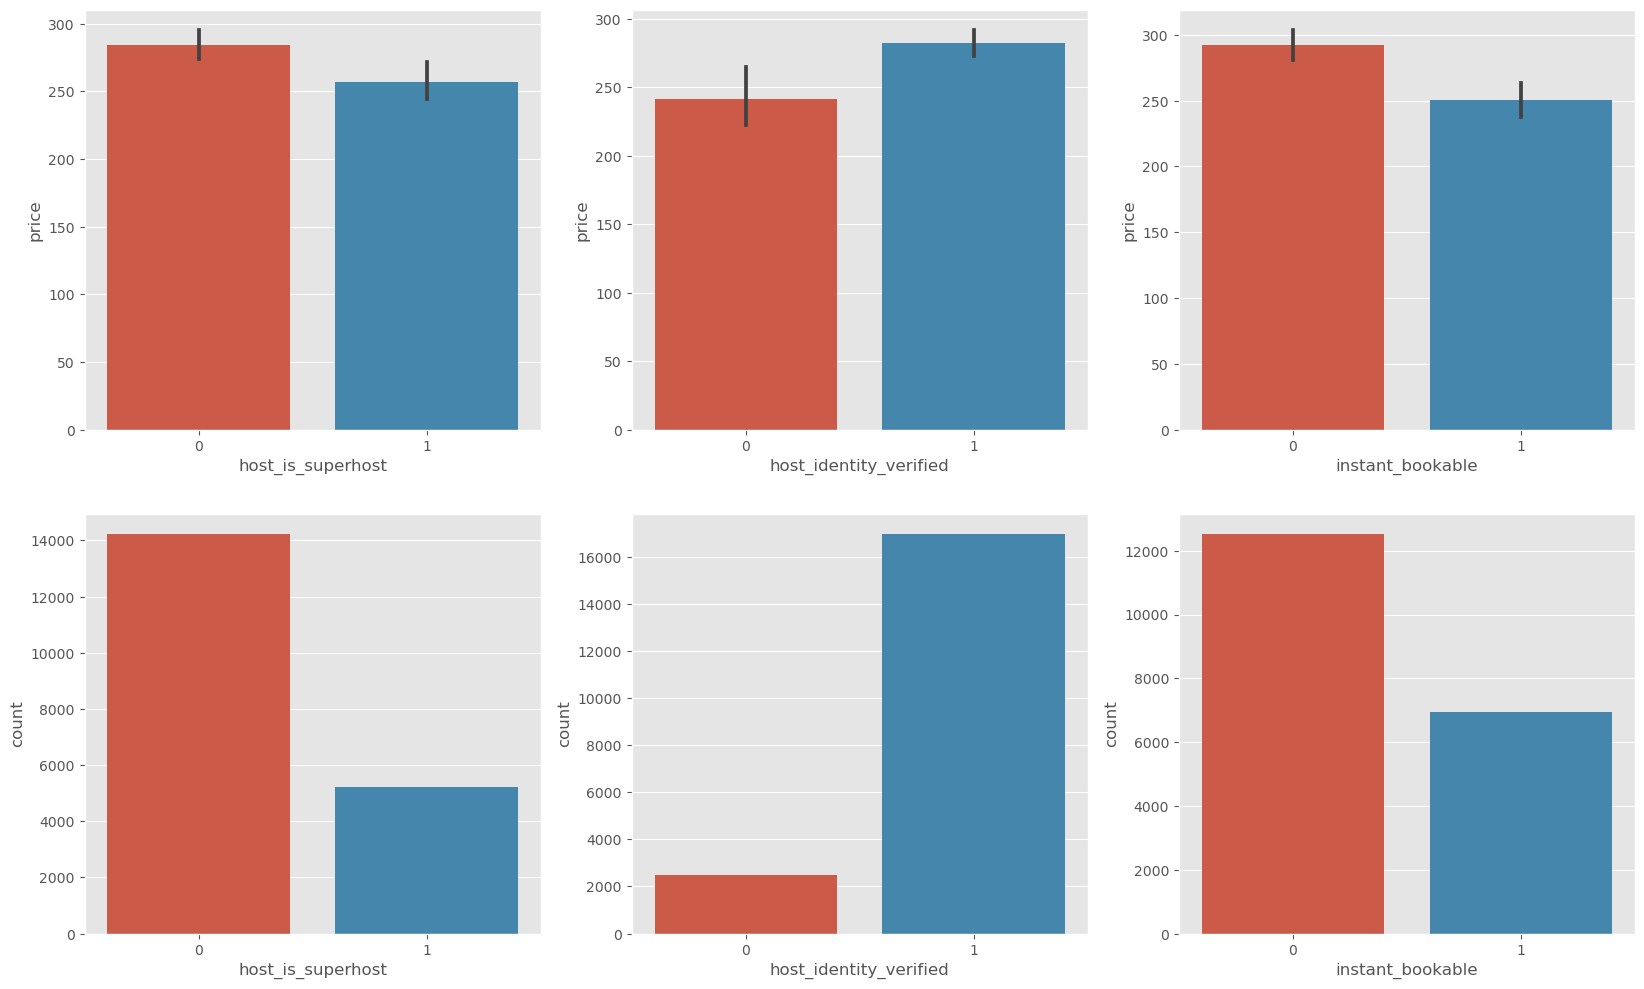

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20,12), squeeze=False)
sns.barplot(ax = axes[0][0], data=la_df_na, x='host_is_superhost', y='price')
sns.barplot(ax = axes[0][1], data=la_df_na, x='host_identity_verified', y='price')
sns.barplot(ax = axes[0][2], data=la_df_na, x='instant_bookable', y='price')

sns.countplot(ax = axes[1][0], data=la_df_na, x='host_is_superhost')
sns.countplot(ax = axes[1][1], data=la_df_na, x='host_identity_verified')
sns.countplot(ax = axes[1][2], data=la_df_na, x='instant_bookable')
plt.show()

* For host verifications, we simply consider the number of different verifications a host has. 

In [21]:
def num_verifications(verifications):
    verifications = verifications[1:-1].split(',')
    try:
        verifications = list(map(lambda x: x.split("'")[1], verifications))
    except:
        verifications = []
    return len(verifications)

la_df_na['host_num_verifications'] = la_df_na['host_verifications'].apply(num_verifications)

* We gather information on the number of bathrooms in a property through the bathroom text.

In [22]:
def split(x):
    x = str(x)
    x = x.split()[0]
    if x == "Half-bath" or x == "Shared":
        x = 0.5
    elif x == "Private":
        x = 1
    return float(x)

la_df_na['number_of_bathrooms'] = la_df_na['bathrooms_text'].apply(split)

* We are given data on both the property and room types. However, we see that the `room_type` feature captures the general description and divides the properties into 3 main types. We also see that there is quite a distinction in airbnb prices based on this variable. Hence, we just consider `room_type` as a relevant feature instead of `property_type`. 

* However, given that `room_type` is a categorical variable, we will convert this into numeric form by transforming it using OneHotEncoding and remove the original column.

<AxesSubplot:xlabel='room_type', ylabel='price'>

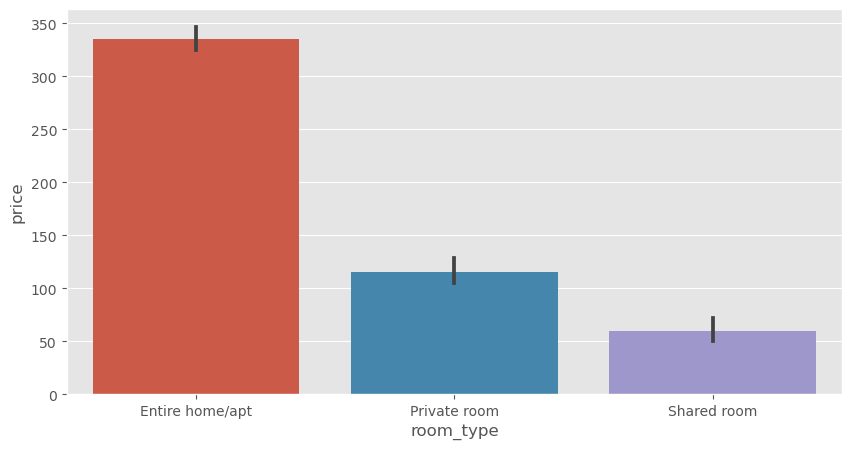

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(data=la_df_na, x='room_type', y='price')

In [24]:
ohe_df = pd.get_dummies(la_df_na.room_type, prefix='Room')
la_df_ohe = pd.concat([la_df_na, ohe_df], axis=1)
la_df_ohe.drop(['room_type'],axis=1, inplace=True)

* We consider the number of amenities offered at a property as our amenities feature

In [25]:
amenities = la_df_ohe['amenities']
amenities_count =[]
for ele in amenities:
    ele = len(ele.split(','))
    amenities_count.append(ele)
la_df_ohe['number_of_amenities'] = amenities_count

In [26]:
la_df_ohe.filter(like='number_of_reviews')

,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
0,3,0,0
1,138,0,0
2,30,0,0
3,378,41,2
4,13,1,0
...,...,...,...
19469,0,0,0
19470,1,0,0
19471,29,29,8
19472,13,13,5


* For the availability feature, we consider just the `availability_365` column which shows how the number of days for which a particular host is available in a year. Further, for the number of reviews, we choose the total number of reviews (`number_of_reviews` column) that a property has received 

* For the actual listings, we just consider the `calculated_host_listings_count` column and ignore the rest. (write this above the review column processing)

* For the review scores, we note that all of the relevant features are pretty highly correlated. Hence, we decide to create one `review_scores_average` column that considers the row-wise average of the pertinent columns.

<AxesSubplot:>

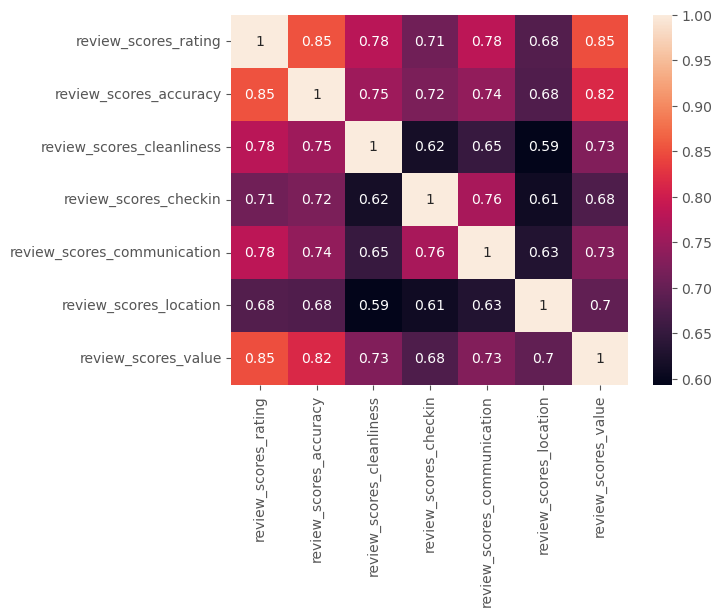

In [27]:
# Firstly, checking for correlation between all review columns
review_cols = la_df_ohe.filter(like='review_scores')
corr = review_cols.corr()
sns.heatmap(corr, annot=True)

In [28]:
la_df_ohe['review_scores_average'] = la_df_ohe.filter(like='review_scores').mean(axis=1)

In [29]:
# Consolidating all relevant data 
neighbourhood_ohe_cols = la_df_ohe.filter(like='neighbourhood_OHE').columns
relevant_columns = ['host_is_superhost', 'calculated_host_listings_count', 'host_num_verifications', 
                    'host_identity_verified','instant_bookable','latitude', 'longitude','Room_Entire home/apt', 
                    'Room_Private room', 'Room_Shared room', 'accommodates', 'number_of_bathrooms',
                    'bedrooms', 'beds', 'number_of_amenities', 'price', 'log_price','availability_365',
                  'number_of_reviews', 'review_scores_average', 'neighbourhood_cleansed']

total_columns = relevant_columns.copy()
total_columns.extend(neighbourhood_ohe_cols)
# cleaned_columns.append(neighbourhood_cols)
la_df_cleaned = la_df_ohe.loc[:, total_columns].copy()
la_df_cleaned.head(2)

,host_is_superhost,calculated_host_listings_count,host_num_verifications,host_identity_verified,instant_bookable,latitude,longitude,Room_Entire home/apt,Room_Private room,Room_Shared room,...,neighbourhood_OHE_West Adams,neighbourhood_OHE_West Hills,neighbourhood_OHE_West Los Angeles,neighbourhood_OHE_Westchester,neighbourhood_OHE_Westlake,neighbourhood_OHE_Westwood,neighbourhood_OHE_Wilmington,neighbourhood_OHE_Windsor Square,neighbourhood_OHE_Winnetka,neighbourhood_OHE_Woodland Hills
0,0,2,2,0,0,33.99211,-118.47600,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,2,1,0,34.12206,-118.26783,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dealing with NA Values

First, we check the variables in our filtered subset of features, that have any NULL values in them. Through this, we note that there are 4 features remaining that contain some missing values.

In [30]:
la_df_cleaned.isna().sum()[lambda x: x > 0].sort_values(ascending=False)

review_scores_average    5539
bedrooms                 2186
beds                      442
number_of_bathrooms        32
dtype: int64

Thus, we deal with these NULL values in our filtered columns in different ways. These are mentioned below:

1. We note that most values in the `review_scores_average` columns are in the 4-5 range. We fill in the NA values for this column by imputing the median.

<AxesSubplot:xlabel='review_scores_average', ylabel='Count'>

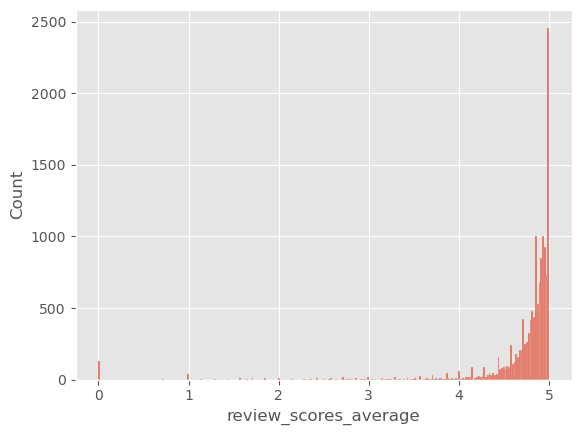

In [31]:
sns.histplot(data=la_df_cleaned, x='review_scores_average')

In [32]:
median_scores = la_df_cleaned['review_scores_average'].median()
la_df_cleaned['review_scores_average'].fillna(value=median_scores, inplace=True)

2. Next, we see that the number of bathrooms, bedrooms and beds are linked with the `accomodates` feature. Therefore, we fill in the NA values for these columns by using the mean of each of these variables, given the value for the `accomodates` variable.  

<AxesSubplot:xlabel='accommodates', ylabel='beds'>

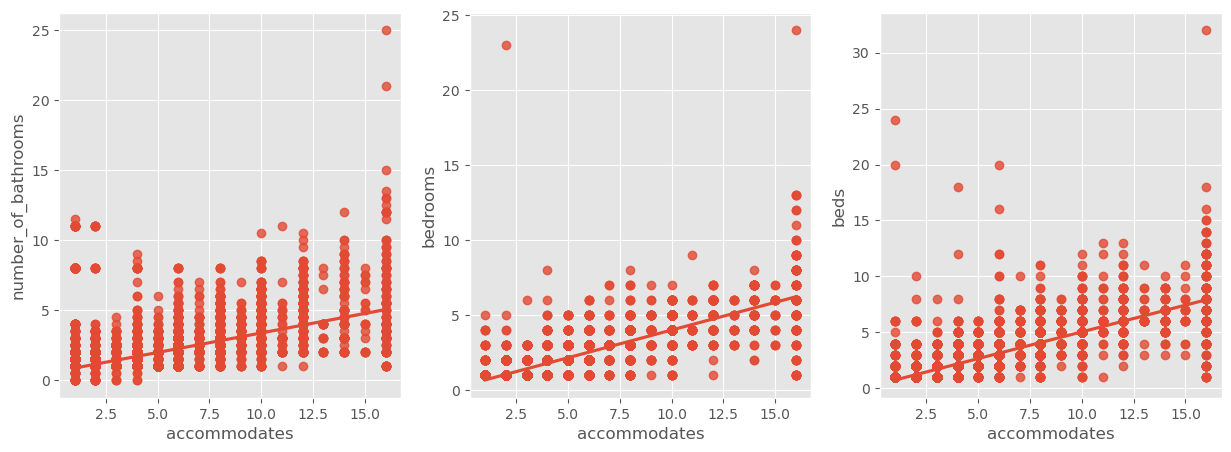

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

sns.regplot(ax = axes[0], data=la_df_cleaned, x='accommodates', y='number_of_bathrooms')
sns.regplot(ax = axes[1], data=la_df_cleaned, x='accommodates', y='bedrooms')
sns.regplot(ax = axes[2], data=la_df_cleaned, x='accommodates', y='beds')

In [34]:
la_df_cleaned['bedrooms'] = la_df_cleaned[['bedrooms', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))
la_df_cleaned['beds'] = la_df_cleaned[['beds', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))
la_df_cleaned['number_of_bathrooms'] = la_df_cleaned[['number_of_bathrooms', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))

Having preprocessed the relevant columns, we now find the top features that are most correlated with our target variable aka `price`. 

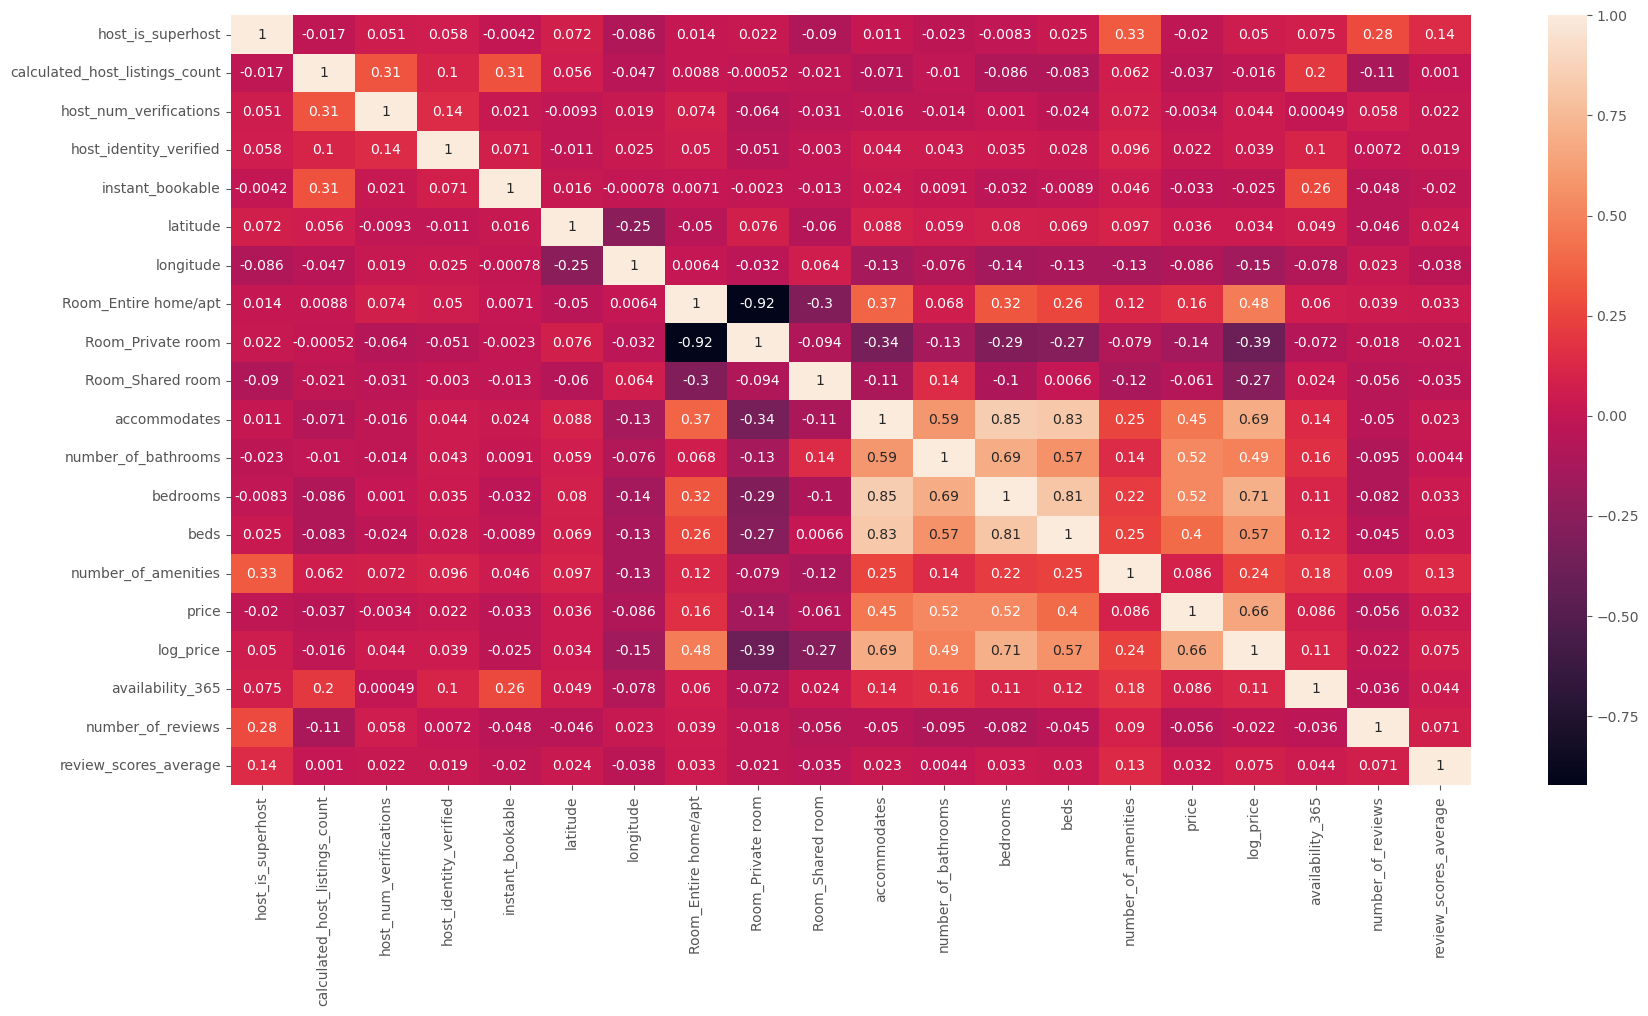

In [35]:
# We consider the correlations of our feature variables, other than the neighbourhood OHE features, with the target variable
corr = la_df_cleaned[relevant_columns].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)
plt.show()

In [36]:
corr["log_price"].sort_values(ascending=False)

log_price                         1.000000
bedrooms                          0.706270
accommodates                      0.686813
price                             0.658926
beds                              0.566160
number_of_bathrooms               0.490782
Room_Entire home/apt              0.480222
number_of_amenities               0.244908
availability_365                  0.113733
review_scores_average             0.075354
host_is_superhost                 0.049954
host_num_verifications            0.044191
host_identity_verified            0.038858
latitude                          0.034098
calculated_host_listings_count   -0.016278
number_of_reviews                -0.021702
instant_bookable                 -0.025462
longitude                        -0.152707
Room_Shared room                 -0.271268
Room_Private room                -0.391480
Name: log_price, dtype: float64

From the correlations, we see that the number of bedrooms, beds, bathrooms and the people accommodated by the property play the most important role in determining the property's price. Therefore, whilst we will make use of all of these filtered columns, since this correlation metric only represents the linear relationship between these variables with price, we do expect these 4 variables to have a high impact on the target variable.

In [37]:
la_df_cleaned.reset_index(drop=True,inplace=True)

# Train-Test Split

To run our different Machine Learning models, we first split our data into training and test subsets. Here, instead of a simple random split, we actually create a Stratified Split based on the `neighbourhood_cleansed` column. We do this to avoid biasing our split by keeping the same proportion of high and low-income neighbourhoods in our train and test splits.

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
for train_index, test_index in split.split(la_df_cleaned, la_df_cleaned["neighbourhood_cleansed"]):
    strat_train_set = la_df_cleaned.loc[train_index]
    strat_test_set = la_df_cleaned.loc[test_index]

In [39]:
train_cols = total_columns.copy()
train_cols.remove('price')
train_cols.remove('log_price')
train_cols.remove('neighbourhood_cleansed')

In [40]:
train_x = strat_train_set[train_cols]
train_y = strat_train_set['log_price']

train_x, train_y = train_x.reset_index(drop=True), train_y.reset_index(drop=True)

In [41]:
test_x = strat_test_set[train_cols]
test_y = strat_test_set['log_price']

For running models, first try simple Linear Regression. Then do it with Cross-Validation (hopefully results improve). Then try other models with cross-validation and see which one gives best results. Then use Grid Search on it if possible. 
Write about best result!

# Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
print(np.exp(train_y))

0        125.0
1        623.0
2        228.0
3        150.0
4        320.0
         ...  
15574    140.0
15575    499.0
15576    113.0
15577    189.0
15578    180.0
Name: log_price, Length: 15579, dtype: float64


In [43]:
print(np.exp(lin_reg.predict(train_x)))

[110.55245479 853.52462162 144.97295985 ... 122.31254216 164.16312461
 156.99970031]


# Model Evaluation Functions

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

def cross_validation_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=10):
    scores = cross_val_score(model, train_x, np.exp(train_y), scoring=scoring, cv=cv)
    rmse = np.sqrt(-scores)
    return rmse, rmse.mean()


def r2Score(model, test_x, test_y):
    
    r2 = r2_score(test_y, model.predict(test_x))
    return r2

In [45]:
# R2 Linear Regression
print(r2Score(lin_reg, test_x, test_y))

0.6789650351357559


In [46]:
from sklearn.metrics import mean_squared_error
price_preds = np.exp(lin_reg.predict(test_x))
lin_mse = mean_squared_error(np.exp(test_y), price_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

448.78182890274974

In [47]:
# Lin Reg Cross Validation MSE
rmse, rmse_mean = cross_validation_score(lin_reg, train_x, train_y)
print(rmse)
print(f"Mean RMSE: {rmse_mean}")

[686.07961287 404.47694004 618.43068906 388.78100289 476.0246103
 460.53146209 453.09583586 383.52556087 445.06028724 441.92900846]
Mean RMSE: 475.7935009682087


# Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_x, train_y)

RandomForestRegressor()

In [49]:
# R2 RF Regression
print(r2Score(forest_reg, test_x, test_y))

0.7607604927151852


In [50]:
from sklearn.metrics import mean_squared_error
price_preds = np.exp(forest_reg.predict(test_x))
forest_mse = mean_squared_error(test_y, price_preds)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

410.89017853974303

In [51]:
# RF Cross Validation MSE
rmse, rmse_mean = cross_validation_score(forest_reg, train_x, train_y)
print(rmse)
print(f"Mean RMSE: {rmse_mean}")

[618.26573147 334.61461515 538.70643936 378.37465867 335.01308475
 472.84875546 405.57744361 331.04898449 466.13387307 458.09579078]
Mean RMSE: 433.86793768102734


# XGBoost Regressor

In [52]:
import xgboost as xg 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 20, seed = 123)
 
# Fitting the model
xgb_r.fit(train_x, train_y)
 
# Predict the model
pred = np.exp(xgb_r.predict(test_x))

/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [53]:
from sklearn.metrics import mean_squared_error
price_preds = np.exp(forest_reg.predict(test_x))
xgbr_mse = mean_squared_error(test_y, price_preds)
xgbr_rmse = np.sqrt(xgbr_mse)
xgbr_rmse

410.89017853974303

In [54]:
# R2 XGB
print(r2Score(xgb_r, test_x, test_y))

0.7537233435282683


In [55]:
# XGB Reg Cross Validation MSE
rmse, rmse_mean = cross_validation_score(xgb_r, train_x, train_y)
print(rmse)
print(f"Mean RMSE: {rmse_mean}")

/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/data.py

[584.31206663 369.32387592 541.09999098 354.75731388 392.83580401
 487.02812916 425.46660521 347.57596626 495.1622782  430.19312801]
Mean RMSE: 442.77551582510034


# Random Search - HyperParameter Tuning

In [56]:
from pprint import pprint
pprint(forest_reg.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [57]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = [
{'n_estimators': [50, 100, 150], 'max_features': [10, 30, 100, 150]},
# {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

random_search = RandomizedSearchCV(forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error', 
                                   return_train_score=True)

random_search.fit(train_x, np.exp(train_y))

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [10, 30, 100, 150],
                                         'n_estimators': [50, 100, 150]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    

415.6731843345936 {'n_estimators': 100, 'max_features': 30}
416.934633743111 {'n_estimators': 150, 'max_features': 10}
432.6967036662482 {'n_estimators': 150, 'max_features': 100}
442.47345417355916 {'n_estimators': 150, 'max_features': 150}
432.51593194746016 {'n_estimators': 50, 'max_features': 100}
446.5062436030813 {'n_estimators': 100, 'max_features': 150}
416.99924926705904 {'n_estimators': 100, 'max_features': 10}
447.3056281910857 {'n_estimators': 50, 'max_features': 150}
423.2190228744052 {'n_estimators': 50, 'max_features': 10}
414.25479248458964 {'n_estimators': 150, 'max_features': 30}


In [59]:
np.sqrt(-cvres["mean_test_score"]).mean()

428.85788442851936

In [60]:
param_grid = [
{'n_estimators': [50, 100, 150], 'max_features': [10, 30, 100, 150]},
# {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

random_search_r2 = RandomizedSearchCV(forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error', 
                                   return_train_score=True)

random_search_r2.fit(train_x, train_y)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [10, 30, 100, 150],
                                         'n_estimators': [50, 100, 150]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [61]:
# R2 random forest random search Regression
print(r2Score(random_search_r2, test_x, test_y))

0.7719247442867356


In [63]:
import joblib

joblib.dump(random_search, "random_search.pkl")
joblib.dump(random_search_r2, "random_search_r2.pkl")

['random_search_r2.pkl']